In [0]:
from __future__ import print_function
from __future__ import division

import pandas as pd
import numpy as np
import urllib.request
import zipfile
import random
import itertools
import math
import os
import datetime
import sys
import random

In [0]:

# !pip3 install pyshp
# !pip3 install descartes
# !pip3 install xgboost
# !pip3 install bayesian_optimization


import shapefile
from shapely.geometry import Polygon
from descartes.patch import PolygonPatch
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.style.use('ggplot')

from sklearn.model_selection import train_test_split, cross_val_score
import socket
import xgboost as xgb
from sklearn.model_selection import cross_val_score
from bayes_opt import bayesian_optimization

from random import randint
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV

import statsmodels.api as sm
import sklearn.model_selection as cv
from scipy import stats
from sklearn import linear_model
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import SGDRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold

import seaborn as sns


%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [0]:
# !pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth 
from oauth2client.client import GoogleCredentials

#Authenticate and create the PyDrive client
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
link = 'https://drive.google.com/open?id=1cQyoWmsTiiWCnlzHeiJ5dtPIRETiHPuo'
fluff, id = link.split('=')
downloaded = drive.CreateFile({'id':id})
downloaded.GetContentFile('jan-2017-2018-2019-combined.csv')

In [0]:
# Function for cross-validation over a grid of parameters

def cv_optimize(clf, parameters, X, y, n_jobs=1, n_folds=5, score_func=None, verbose=0):
    if score_func:
        gs = GridSearchCV(clf, param_grid=parameters, cv=n_folds, n_jobs=n_jobs, scoring=score_func, verbose=verbose)
    else:
        gs = GridSearchCV(clf, param_grid=parameters, n_jobs=n_jobs, cv=n_folds, verbose=verbose)
    gs.fit(X, y)
    print("BEST", gs.best_params_, gs.best_score_, gs.cv_results_, gs.scorer_)
    print("Best score: ", gs.best_score_)
    best = gs.best_estimator_
    return best

## NYC Taxi Data

#### Download the Trip Record Data

In [6]:
# For downloading TLC data for multiple months in the same year
'''
for month in range(1,2):
    urllib.request.urlretrieve("https://s3.amazonaws.com/nyc-tlc/trip+data/"+ \
                               "yellow_tripdata_2018-{0:0=2d}.csv".format(month), 
                               "nyc.2018-{0:0=2d}.csv".format(month))
'''

# For downloading TLC data for a single month in multiple years
'''
month = 1
for year in range(2017, 2020):
    urllib.request.urlretrieve("https://s3.amazonaws.com/nyc-tlc/trip+data/"+ \
                               "yellow_tripdata_{0:4d}-{1:0=2d}.csv".format(year, month), 
                               "nyc.{0:4d}-{1:0=2d}.csv".format(year, month))
'''

'\nmonth = 1\nfor year in range(2017, 2020):\n    urllib.request.urlretrieve("https://s3.amazonaws.com/nyc-tlc/trip+data/"+                                "yellow_tripdata_{0:4d}-{1:0=2d}.csv".format(year, month), \n                               "nyc.{0:4d}-{1:0=2d}.csv".format(year, month))\n'

In [0]:
import dask.dataframe as dd

nyc_df = dd.read_csv('jan-2017-2018-2019-combined.csv', parse_dates=['tpep_pickup_datetime', 'tpep_dropoff_datetime'])
nyc_df = nyc_df.compute()


In [8]:
nyc_df = nyc_df.set_index('tpep_pickup_datetime')
nyc_df.describe()

,VendorID,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount
count,2.613779e+07,2.613779e+07,2.613779e+07,2.613779e+07,2.613779e+07,2.613779e+07,2.613779e+07,2.613779e+07,2.613779e+07,2.613779e+07,2.613779e+07,2.613779e+07,2.613779e+07,2.613779e+07
mean,1.578038e+00,1.603406e+00,2.806822e+00,1.045081e+00,1.646335e+02,1.626697e+02,1.315090e+00,1.234102e+01,3.252228e-01,4.973188e-01,1.796207e+00,2.970778e-01,2.995632e-01,1.556036e+01
std,5.114147e-01,1.253912e+00,3.724228e+01,5.444552e-01,6.647977e+01,7.046584e+01,4.832841e-01,2.152400e+02,4.650344e-01,4.848126e-02,2.522775e+00,1.792202e+00,1.561743e-02,2.154229e+02
min,1.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,-4.500000e+02,-6.000000e+01,-5.000000e-01,-8.880000e+01,-7.000000e+01,-3.000000e-01,-4.503000e+02
25%,1.000000e+00,1.000000e+00,9.200000e-01,1.000000e+00,1.140000e+02,1.130000e+02,1.000000e+00,6.000000e+00,0.000000e+00,5.000000e-01,0.000000e+00,0.000000e+00,3.000000e-01,8.300000e+00
50%,2.000000e+00,1.000000e+00,1.570000e+00,1.000000e+00,1.620000e+02,1.620000e+02,1.000000e+00,9.000000e+00,0.000000e+00,5.000000e-01,1.360000e+00,0.000000e+00,3.000000e-01,1.130000e+01
75%,2.000000e+00,2.000000e+00,2.870000e+00,1.000000e+00,2.340000e+02,2.340000e+02,2.000000e+00,1.350000e+01,5.000000e-01,5.000000e-01,2.320000e+00,0.000000e+00,3.000000e-01,1.660000e+01
max,4.000000e+00,9.000000e+00,1.894838e+05,9.900000e+01,2.650000e+02,2.650000e+02,5.000000e+00,6.259008e+05,5.353800e+02,6.080000e+01,9.999900e+02,3.288000e+03,1.000000e+00,6.259016e+05


#### Remove the rows that don't belong to the choosen time frame

In [9]:
# Initially
# nyc_df = nyc_df.loc[(nyc_df.index.month==1) & ((nyc_df.index.year==2017) | (nyc_df.index.year==2018))]

# New
nyc_df = nyc_df.loc[(nyc_df.index.month==1) & ((nyc_df.index.year==2017) | (nyc_df.index.year==2018) | (nyc_df.index.year==2019))]
nyc_df.describe()

,VendorID,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount
count,2.613691e+07,2.613691e+07,2.613691e+07,2.613691e+07,2.613691e+07,2.613691e+07,2.613691e+07,2.613691e+07,2.613691e+07,2.613691e+07,2.613691e+07,2.613691e+07,2.613691e+07,2.613691e+07
mean,1.578024e+00,1.603394e+00,2.806808e+00,1.045080e+00,1.646339e+02,1.626699e+02,1.315085e+00,1.234096e+01,3.252198e-01,4.973189e-01,1.796216e+00,2.970779e-01,2.995632e-01,1.556031e+01
std,5.114175e-01,1.253901e+00,3.724290e+01,5.444568e-01,6.647967e+01,7.046575e+01,4.832829e-01,2.152436e+02,4.650397e-01,4.848100e-02,2.522774e+00,1.792212e+00,1.561714e-02,2.154265e+02
min,1.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,-4.500000e+02,-6.000000e+01,-5.000000e-01,-8.880000e+01,-7.000000e+01,-3.000000e-01,-4.503000e+02
25%,1.000000e+00,1.000000e+00,9.200000e-01,1.000000e+00,1.140000e+02,1.130000e+02,1.000000e+00,6.000000e+00,0.000000e+00,5.000000e-01,0.000000e+00,0.000000e+00,3.000000e-01,8.300000e+00
50%,2.000000e+00,1.000000e+00,1.570000e+00,1.000000e+00,1.620000e+02,1.620000e+02,1.000000e+00,9.000000e+00,0.000000e+00,5.000000e-01,1.360000e+00,0.000000e+00,3.000000e-01,1.130000e+01
75%,2.000000e+00,2.000000e+00,2.870000e+00,1.000000e+00,2.340000e+02,2.340000e+02,2.000000e+00,1.350000e+01,5.000000e-01,5.000000e-01,2.320000e+00,0.000000e+00,3.000000e-01,1.660000e+01
max,4.000000e+00,9.000000e+00,1.894838e+05,9.900000e+01,2.650000e+02,2.650000e+02,5.000000e+00,6.259008e+05,5.353800e+02,6.080000e+01,9.999900e+02,3.288000e+03,1.000000e+00,6.259016e+05


#### Check for null values

In [10]:
nyc_df.isnull().sum()

VendorID                 0
tpep_dropoff_datetime    0
passenger_count          0
trip_distance            0
RatecodeID               0
store_and_fwd_flag       0
PULocationID             0
DOLocationID             0
payment_type             0
fare_amount              0
extra                    0
mta_tax                  0
tip_amount               0
tolls_amount             0
improvement_surcharge    0
total_amount             0
dtype: int64

#### Sort the data based on the date information and reindex it

In [11]:
nyc_df = nyc_df.sample(frac = 0.8) 
nyc_df.sort_values(by=['tpep_pickup_datetime'], inplace=True)
nyc_df.reset_index(inplace=True)
nyc_df.head()

,tpep_pickup_datetime,VendorID,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount
0,2017-01-01 00:00:02,1,2017-01-01 00:03:50,1,0.50,1,N,48,48,2,4.0,0.5,0.5,0.00,0.00,0.3,5.30
1,2017-01-01 00:00:02,2,2017-01-01 00:39:22,4,7.75,1,N,186,36,1,22.0,0.5,0.5,4.66,0.00,0.3,27.96
2,2017-01-01 00:00:03,1,2017-01-01 00:06:58,1,0.80,1,N,162,161,1,6.0,0.5,0.5,1.45,0.00,0.3,8.75
3,2017-01-01 00:00:05,1,2017-01-01 00:08:33,2,0.90,1,N,48,50,1,7.0,0.5,0.5,0.00,0.00,0.3,8.30
4,2017-01-01 00:00:05,2,2017-01-01 00:15:36,1,8.47,1,N,138,262,1,24.0,0.5,0.5,7.71,5.54,0.3,38.55


In [12]:
nyc_df.describe()

,VendorID,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount
count,2.090953e+07,2.090953e+07,2.090953e+07,2.090953e+07,2.090953e+07,2.090953e+07,2.090953e+07,2.090953e+07,2.090953e+07,2.090953e+07,2.090953e+07,2.090953e+07,2.090953e+07,2.090953e+07
mean,1.578032e+00,1.603460e+00,2.808369e+00,1.045100e+00,1.646264e+02,1.626683e+02,1.315080e+00,1.230089e+01,3.252131e-01,4.973209e-01,1.796282e+00,2.971372e-01,2.995632e-01,1.552036e+01
std,5.113715e-01,1.253947e+00,4.159849e+01,5.441982e-01,6.647869e+01,7.047746e+01,4.832929e-01,1.430484e+02,4.681149e-01,4.958176e-02,2.522253e+00,1.692989e+00,1.561950e-02,1.433353e+02
min,1.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,-4.500000e+02,-6.000000e+01,-5.000000e-01,-8.880000e+01,-7.000000e+01,-3.000000e-01,-4.503000e+02
25%,1.000000e+00,1.000000e+00,9.200000e-01,1.000000e+00,1.140000e+02,1.130000e+02,1.000000e+00,6.000000e+00,0.000000e+00,5.000000e-01,0.000000e+00,0.000000e+00,3.000000e-01,8.300000e+00
50%,2.000000e+00,1.000000e+00,1.560000e+00,1.000000e+00,1.620000e+02,1.620000e+02,1.000000e+00,9.000000e+00,0.000000e+00,5.000000e-01,1.360000e+00,0.000000e+00,3.000000e-01,1.130000e+01
75%,2.000000e+00,2.000000e+00,2.870000e+00,1.000000e+00,2.340000e+02,2.340000e+02,2.000000e+00,1.350000e+01,5.000000e-01,5.000000e-01,2.320000e+00,0.000000e+00,3.000000e-01,1.660000e+01
max,4.000000e+00,9.000000e+00,1.894838e+05,9.900000e+01,2.650000e+02,2.650000e+02,5.000000e+00,5.385792e+05,5.353800e+02,6.080000e+01,9.999900e+02,9.507000e+02,1.000000e+00,5.385800e+05


#### Check for anomalies in the dataset and drop them

In [0]:
duration = nyc_df.tpep_dropoff_datetime - nyc_df.tpep_pickup_datetime
speed = (nyc_df.trip_distance/duration.dt.seconds)*60

nyc_df = nyc_df.loc[(duration > pd.to_timedelta('00:12:00')) & ((speed < 90.0) | (speed > 0))]


In [14]:
nyc_df = nyc_df[nyc_df['total_amount'] >= 0]
nyc_df = nyc_df[nyc_df['extra'] >= 0]
nyc_df = nyc_df[nyc_df['mta_tax'] >= 0]
nyc_df = nyc_df[nyc_df['fare_amount'] >= 0]
nyc_df = nyc_df[nyc_df['tolls_amount'] >= 0]
nyc_df = nyc_df[nyc_df['improvement_surcharge'] >= 0]

nyc_df.describe()

,VendorID,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount
count,8.682070e+06,8.682070e+06,8.682070e+06,8.682070e+06,8.682070e+06,8.682070e+06,8.682070e+06,8.682070e+06,8.682070e+06,8.682070e+06,8.682070e+06,8.682070e+06,8.682070e+06,8.682070e+06
mean,1.583269e+00,1.615280e+00,5.061918e+00,1.078206e+00,1.606148e+02,1.566089e+02,1.279747e+00,1.962680e+01,3.389453e-01,4.970130e-01,2.810089e+00,6.924363e-01,2.999491e-01,2.427078e+01
std,5.098916e-01,1.257658e+00,4.736217e+00,4.447453e-01,6.468259e+01,7.231309e+01,4.641323e-01,1.832236e+02,5.332803e-01,3.855071e-02,3.227811e+00,2.451206e+00,3.970005e-03,1.834992e+02
min,1.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.000000e+00,1.000000e+00,2.100000e+00,1.000000e+00,1.290000e+02,1.000000e+02,1.000000e+00,1.150000e+01,0.000000e+00,5.000000e-01,0.000000e+00,0.000000e+00,3.000000e-01,1.430000e+01
50%,2.000000e+00,1.000000e+00,3.200000e+00,1.000000e+00,1.610000e+02,1.610000e+02,1.000000e+00,1.500000e+01,0.000000e+00,5.000000e-01,2.360000e+00,0.000000e+00,3.000000e-01,1.830000e+01
75%,2.000000e+00,2.000000e+00,6.080000e+00,1.000000e+00,2.300000e+02,2.310000e+02,2.000000e+00,2.250000e+01,5.000000e-01,5.000000e-01,3.760000e+00,0.000000e+00,3.000000e-01,2.680000e+01
max,4.000000e+00,9.000000e+00,2.677000e+02,9.900000e+01,2.650000e+02,2.650000e+02,4.000000e+00,5.385792e+05,2.500000e+01,3.000000e+00,4.448000e+02,9.507000e+02,1.000000e+00,5.385800e+05


In [15]:
nyc_df.head()

,tpep_pickup_datetime,VendorID,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount
1,2017-01-01 00:00:02,2,2017-01-01 00:39:22,4,7.75,1,N,186,36,1,22.0,0.5,0.5,4.66,0.00,0.3,27.96
4,2017-01-01 00:00:05,2,2017-01-01 00:15:36,1,8.47,1,N,138,262,1,24.0,0.5,0.5,7.71,5.54,0.3,38.55
7,2017-01-01 00:00:06,1,2017-01-01 00:23:37,2,12.60,5,N,161,265,1,60.0,0.0,0.0,10.00,0.00,0.3,70.30
9,2017-01-01 00:00:10,1,2017-01-01 00:24:52,1,6.60,1,N,186,232,2,23.0,0.5,0.5,0.00,0.00,0.3,24.30
11,2017-01-01 00:00:12,1,2017-01-01 00:12:53,1,1.70,1,N,125,45,2,9.5,0.5,0.5,0.00,0.00,0.3,10.80


## NYC Taxi Zones

In [0]:

# Download the location Data
urllib.request.urlretrieve("https://s3.amazonaws.com/nyc-tlc/misc/taxi_zones.zip", "taxi_zones.zip")
with zipfile.ZipFile("taxi_zones.zip","r") as zip_ref:
    zip_ref.extractall("./datasets/taxi_zones/shape")


In [0]:
def get_lat_lon(sf):
    content = []
    for sr in sf.shapeRecords():
        shape = sr.shape
        rec = sr.record
        loc_id = rec[shp_dic['LocationID']]
        
        x = (shape.bbox[0]+shape.bbox[2])/2
        y = (shape.bbox[1]+shape.bbox[3])/2
        
        content.append((loc_id, x, y))
    return pd.DataFrame(content, columns=["LocationID", "longitude", "latitude"])

#### Convert shape file to data frame

In [18]:
sf = shapefile.Reader("datasets/taxi_zones/shape/taxi_zones.shp")
fields_name = [field[0] for field in sf.fields[1:]]
shp_dic = dict(zip(fields_name, list(range(len(fields_name)))))
attributes = sf.records()
shp_attr = [dict(zip(fields_name, attr)) for attr in attributes]

loc_df = pd.DataFrame(shp_attr).join(get_lat_lon(sf).set_index("LocationID"), on="LocationID")
loc_df.head()

,OBJECTID,Shape_Leng,Shape_Area,zone,LocationID,borough,longitude,latitude
0,1,0.116357,0.000782,Newark Airport,1,EWR,9.366817e+05,190522.130278
1,2,0.433470,0.004866,Jamaica Bay,2,Queens,1.033536e+06,161853.982300
2,3,0.084341,0.000314,Allerton/Pelham Gardens,3,Bronx,1.027136e+06,254730.010849
3,4,0.043567,0.000112,Alphabet City,4,Manhattan,9.904240e+05,203100.040432
4,5,0.092146,0.000498,Arden Heights,5,Staten Island,9.321332e+05,139954.541936


#### Remove location id's that are outside of the Manhattan

In [19]:
loc_df = loc_df[loc_df.borough == "Manhattan"]
loc_df.head()

,OBJECTID,Shape_Leng,Shape_Area,zone,LocationID,borough,longitude,latitude
3,4,0.043567,0.000112,Alphabet City,4,Manhattan,990424.019570,203100.040432
11,12,0.036661,0.000042,Battery Park,12,Manhattan,979889.680922,195215.447490
12,13,0.050281,0.000149,Battery Park City,13,Manhattan,979844.241304,198508.159318
23,24,0.047000,0.000061,Bloomingdale,24,Manhattan,993795.402611,231438.438453
40,41,0.052793,0.000143,Central Harlem,41,Manhattan,997895.956595,232264.009901


#### Convert location ids that belong to Manhattan into a list

In [20]:
manhattan_loc_id_list = loc_df["LocationID"].tolist()
print(manhattan_loc_id_list)

[4, 12, 13, 24, 41, 42, 43, 45, 48, 50, 68, 74, 75, 79, 87, 88, 90, 100, 103, 103, 103, 103, 103, 103, 103, 103, 103, 107, 113, 114, 116, 120, 125, 127, 128, 137, 140, 141, 142, 143, 144, 148, 151, 152, 153, 158, 161, 162, 163, 164, 166, 170, 186, 194, 202, 209, 211, 224, 229, 230, 231, 232, 233, 234, 236, 237, 238, 239, 243, 244, 246, 249, 261, 262, 263]


## Intersect NYC Taxi and NYC Taxi Zone Data

#### Remove taxi rides that didn't originate from Manhattan

In [21]:
nyc_df = nyc_df[nyc_df['PULocationID'].isin(manhattan_loc_id_list)]

nyc_df.head()

,tpep_pickup_datetime,VendorID,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount
1,2017-01-01 00:00:02,2,2017-01-01 00:39:22,4,7.75,1,N,186,36,1,22.0,0.5,0.5,4.66,0.0,0.3,27.96
7,2017-01-01 00:00:06,1,2017-01-01 00:23:37,2,12.60,5,N,161,265,1,60.0,0.0,0.0,10.00,0.0,0.3,70.30
9,2017-01-01 00:00:10,1,2017-01-01 00:24:52,1,6.60,1,N,186,232,2,23.0,0.5,0.5,0.00,0.0,0.3,24.30
11,2017-01-01 00:00:12,1,2017-01-01 00:12:53,1,1.70,1,N,125,45,2,9.5,0.5,0.5,0.00,0.0,0.3,10.80
13,2017-01-01 00:00:13,2,2017-01-01 00:15:39,1,4.68,1,N,140,223,1,16.5,0.5,0.5,4.45,0.0,0.3,22.25


## Weather Data

#### Import the weather dataset

In [0]:
link = 'https://drive.google.com/open?id=1IbU83VjSs-VIVnI_6ov1mv3JKOkaIVU8'
fluff, id = link.split('=')
downloaded = drive.CreateFile({'id':id})
downloaded.GetContentFile('./datasets/weather_data.csv')

In [23]:
weather_df = pd.read_csv("./datasets/weather_data.csv")
weather_df.describe()

,year,month,day,temp_high,temp_avg,temp_low,dew_high,dew_avg,dew_low,humidity_high,humidity_avg,humidity_low,sea_level_press_high,sea_level_press_avg,sea_level_press_low,visibility_high,visibility_avg,visibility_low,wind_high,wind_avg,wind_high.1
count,1399.000000,1399.000000,1399.000000,1399.000000,1399.000000,1399.000000,1373.000000,1373.000000,1373.000000,1399.000000,1399.000000,1399.000000,1368.000000,1368.000000,1368.000000,1365.000000,1365.000000,1365.000000,1242.000000,1242.000000,1224.000000
mean,2017.436026,6.333810,15.673338,17.787706,14.033595,10.021444,9.314639,6.021850,2.324836,79.463188,62.634739,45.288063,1020.815058,1017.002924,1013.330409,15.936996,13.950183,9.967033,21.516908,7.925121,35.241830
std,1.100144,3.365345,8.832640,10.035985,9.574623,9.304704,10.092072,10.621686,11.212795,16.034027,14.659179,16.013873,6.982799,7.385705,7.991430,0.433716,2.970605,6.169022,7.009614,3.909331,10.639811
min,2016.000000,1.000000,1.000000,-11.000000,-14.000000,-18.000000,-24.000000,-27.000000,-28.000000,31.000000,22.000000,9.000000,998.000000,994.000000,979.000000,8.000000,1.000000,0.000000,8.000000,0.000000,11.000000
25%,2016.000000,3.000000,8.000000,9.000000,6.000000,3.000000,2.000000,-2.000000,-7.000000,67.000000,52.000000,34.000000,1016.000000,1012.000000,1009.000000,16.000000,13.000000,3.000000,16.000000,5.000000,27.000000
50%,2017.000000,6.000000,16.000000,18.000000,14.000000,11.000000,11.000000,7.000000,3.000000,82.000000,63.000000,43.000000,1021.000000,1017.000000,1014.000000,16.000000,16.000000,13.000000,21.000000,7.000000,34.000000
75%,2018.000000,9.000000,23.000000,27.000000,23.000000,18.000000,18.000000,15.000000,12.000000,93.000000,73.000000,54.000000,1025.000000,1022.000000,1019.000000,16.000000,16.000000,16.000000,24.000000,10.000000,40.000000
max,2019.000000,12.000000,31.000000,36.000000,32.000000,28.000000,26.000000,24.000000,22.000000,100.000000,98.000000,96.000000,1044.000000,1041.000000,1036.000000,16.000000,16.000000,16.000000,121.000000,29.000000,77.000000


#### Check the types of the columns

In [24]:
weather_df.dtypes

year                      int64
month                     int64
day                       int64
temp_high                 int64
temp_avg                  int64
temp_low                  int64
dew_high                float64
dew_avg                 float64
dew_low                 float64
humidity_high             int64
humidity_avg              int64
humidity_low              int64
sea_level_press_high    float64
sea_level_press_avg     float64
sea_level_press_low     float64
visibility_high         float64
visibility_avg          float64
visibility_low          float64
wind_high               float64
wind_avg                float64
wind_high.1             float64
precipitation            object
events                   object
dtype: object

#### Convert events column into multiple columns

In [25]:
# weather_df['event_rain'] = 0
# weather_df['event_fog'] = 0
# weather_df['event_snow'] = 0

# for index, row in weather_df.iterrows():
#     if(isinstance(weather_df.events[index], str)):
#         if("Rain" in weather_df.events[index]):
#             weather_df.event_rain[index] = 1

#         if("Fog" in weather_df.events[index]):
#             weather_df.event_fog[index] = 1

#         if("Snow" in weather_df.events[index]):
#             weather_df.event_snow[index] = 1

# weather_df = weather_df.drop("events", axis = 1)

weather_df.head()


,year,month,day,temp_high,temp_avg,temp_low,dew_high,dew_avg,dew_low,humidity_high,humidity_avg,humidity_low,sea_level_press_high,sea_level_press_avg,sea_level_press_low,visibility_high,visibility_avg,visibility_low,wind_high,wind_avg,wind_high.1,precipitation,events
0,2016,1,1,6,3,1,-3.0,-5.0,-9.0,59,52,44,1018.0,1017.0,1015.0,16.0,16.0,16.0,27.0,12.0,42.0,0,NaN
1,2016,1,2,4,2,0,-7.0,-8.0,-9.0,52,46,40,1019.0,1016.0,1014.0,16.0,16.0,16.0,24.0,11.0,37.0,0,NaN
2,2016,1,3,7,4,2,-5.0,-6.0,-7.0,56,47,37,1014.0,1011.0,1009.0,16.0,16.0,16.0,27.0,13.0,42.0,0,NaN
3,2016,1,4,2,-4,-10,-5.0,-13.0,-18.0,59,44,28,1027.0,1017.0,1011.0,16.0,16.0,16.0,34.0,14.0,50.0,0,NaN
4,2016,1,5,-2,-7,-12,-17.0,-19.0,-21.0,58,41,24,1037.0,1035.0,1031.0,16.0,16.0,16.0,32.0,8.0,48.0,0,NaN


#### Add primary key to be used in the NYC taxi data

In [0]:
# weather_df.insert(0, "primary_key", "") 

# for index, row in weather_df.iterrows():
#     key = str(row['year'])
    
#     if (row['month'] == 0) or (row['month'] == 1) or (row['month'] == 2) or (row['month'] == 3) or (row['month'] == 4) or (row['month'] == 5) or (row['month'] == 6) or (row['month'] == 7) or (row['month'] == 8) or (row['month'] == 9):
#         key = key + "-0" + str(row['month'])
#     else:
#         key = key + "-" + str(row['month'])
        
#     if (row['day'] == 0) or (row['day'] == 1) or (row['day'] == 2) or (row['day'] == 3) or (row['day'] == 4) or (row['day'] == 5) or (row['day'] == 6) or (row['day'] == 7) or (row['day'] == 8) or (row['day'] == 9):
#         key = key + "-0" + str(row['day'])
#     else:
#         key = key + "-" + str(row['day'])
        
#     weather_df.primary_key[index] = key

weather_df = weather_df.assign(primary_key = weather_df.year.astype(str) + '-' + weather_df.month.astype(str) + '-' + weather_df.day.astype(str))


#### Sort the data based on the date information and reindex it

In [27]:
weather_df['primary_key'] = pd.to_datetime(weather_df['primary_key'])
weather_df = weather_df.set_index('primary_key')
weather_df.precipitation = weather_df.precipitation.replace('T', np.nan)


# weather_df.reset_index(inplace=True)
weather_df.head()

,year,month,day,temp_high,temp_avg,temp_low,dew_high,dew_avg,dew_low,humidity_high,humidity_avg,humidity_low,sea_level_press_high,sea_level_press_avg,sea_level_press_low,visibility_high,visibility_avg,visibility_low,wind_high,wind_avg,wind_high.1,precipitation,events
primary_key,,,,,,,,,,,,,,,,,,,,,,,
2016-01-01,2016,1,1,6,3,1,-3.0,-5.0,-9.0,59,52,44,1018.0,1017.0,1015.0,16.0,16.0,16.0,27.0,12.0,42.0,0,NaN
2016-01-02,2016,1,2,4,2,0,-7.0,-8.0,-9.0,52,46,40,1019.0,1016.0,1014.0,16.0,16.0,16.0,24.0,11.0,37.0,0,NaN
2016-01-03,2016,1,3,7,4,2,-5.0,-6.0,-7.0,56,47,37,1014.0,1011.0,1009.0,16.0,16.0,16.0,27.0,13.0,42.0,0,NaN
2016-01-04,2016,1,4,2,-4,-10,-5.0,-13.0,-18.0,59,44,28,1027.0,1017.0,1011.0,16.0,16.0,16.0,34.0,14.0,50.0,0,NaN
2016-01-05,2016,1,5,-2,-7,-12,-17.0,-19.0,-21.0,58,41,24,1037.0,1035.0,1031.0,16.0,16.0,16.0,32.0,8.0,48.0,0,NaN


In [28]:
weather_df.dtypes

year                      int64
month                     int64
day                       int64
temp_high                 int64
temp_avg                  int64
temp_low                  int64
dew_high                float64
dew_avg                 float64
dew_low                 float64
humidity_high             int64
humidity_avg              int64
humidity_low              int64
sea_level_press_high    float64
sea_level_press_avg     float64
sea_level_press_low     float64
visibility_high         float64
visibility_avg          float64
visibility_low          float64
wind_high               float64
wind_avg                float64
wind_high.1             float64
precipitation            object
events                   object
dtype: object

In [0]:
weather_df['precipitation'] = weather_df['precipitation'].astype(str).astype(float)

#### Check for missing values

In [30]:
weather_df.isnull().sum()

year                      0
month                     0
day                       0
temp_high                 0
temp_avg                  0
temp_low                  0
dew_high                 26
dew_avg                  26
dew_low                  26
humidity_high             0
humidity_avg              0
humidity_low              0
sea_level_press_high     31
sea_level_press_avg      31
sea_level_press_low      31
visibility_high          34
visibility_avg           34
visibility_low           34
wind_high               157
wind_avg                157
wind_high.1             175
precipitation           121
events                  841
dtype: int64

In [31]:
weather_df.dtypes

year                      int64
month                     int64
day                       int64
temp_high                 int64
temp_avg                  int64
temp_low                  int64
dew_high                float64
dew_avg                 float64
dew_low                 float64
humidity_high             int64
humidity_avg              int64
humidity_low              int64
sea_level_press_high    float64
sea_level_press_avg     float64
sea_level_press_low     float64
visibility_high         float64
visibility_avg          float64
visibility_low          float64
wind_high               float64
wind_avg                float64
wind_high.1             float64
precipitation           float64
events                   object
dtype: object

#### Fill rows with missing values using interpolation

In [32]:
weather_df = weather_df.interpolate(method="linear")
weather_df.isnull().sum()

year                      0
month                     0
day                       0
temp_high                 0
temp_avg                  0
temp_low                  0
dew_high                  0
dew_avg                   0
dew_low                   0
humidity_high             0
humidity_avg              0
humidity_low              0
sea_level_press_high      0
sea_level_press_avg       0
sea_level_press_low       0
visibility_high           0
visibility_avg            0
visibility_low            0
wind_high                 0
wind_avg                  0
wind_high.1               0
precipitation             0
events                  841
dtype: int64

# Quick Validation

In [33]:
nyc_df.head()

,tpep_pickup_datetime,VendorID,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount
1,2017-01-01 00:00:02,2,2017-01-01 00:39:22,4,7.75,1,N,186,36,1,22.0,0.5,0.5,4.66,0.0,0.3,27.96
7,2017-01-01 00:00:06,1,2017-01-01 00:23:37,2,12.60,5,N,161,265,1,60.0,0.0,0.0,10.00,0.0,0.3,70.30
9,2017-01-01 00:00:10,1,2017-01-01 00:24:52,1,6.60,1,N,186,232,2,23.0,0.5,0.5,0.00,0.0,0.3,24.30
11,2017-01-01 00:00:12,1,2017-01-01 00:12:53,1,1.70,1,N,125,45,2,9.5,0.5,0.5,0.00,0.0,0.3,10.80
13,2017-01-01 00:00:13,2,2017-01-01 00:15:39,1,4.68,1,N,140,223,1,16.5,0.5,0.5,4.45,0.0,0.3,22.25


In [34]:
nyc_df.tail()

,tpep_pickup_datetime,VendorID,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount
20909519,2019-01-31 23:59:51,2,2019-02-01 00:28:56,6,11.23,1,N,125,247,1,34.0,0.5,0.5,7.06,0.0,0.3,42.36
20909520,2019-01-31 23:59:51,1,2019-02-01 00:23:33,2,6.50,1,N,4,41,1,21.5,1.0,0.5,3.50,0.0,0.3,26.80
20909521,2019-01-31 23:59:51,1,2019-02-01 00:30:54,1,6.90,1,Y,158,7,1,25.5,0.5,0.5,5.35,0.0,0.3,32.15
20909522,2019-01-31 23:59:52,1,2019-02-01 00:34:16,1,9.80,1,Y,164,160,2,33.0,0.5,0.5,0.00,0.0,0.3,34.30
20909526,2019-01-31 23:59:54,2,2019-02-01 00:12:36,1,4.03,1,N,79,146,2,13.5,0.5,0.5,0.00,0.0,0.3,14.80


In [35]:
nyc_df['tpep_pickup_datetime'].dt.to_period('D')

1           2017-01-01
7           2017-01-01
9           2017-01-01
11          2017-01-01
13          2017-01-01
               ...    
20909519    2019-01-31
20909520    2019-01-31
20909521    2019-01-31
20909522    2019-01-31
20909526    2019-01-31
Name: tpep_pickup_datetime, Length: 7354109, dtype: period[D]

In [0]:
# nyc_df['tpep_pickup_datetime'].dt.to_period('D').to_datetime()
nyc_df = nyc_df.set_index(nyc_df['tpep_pickup_datetime'].dt.strftime("%Y-%m-%d"))

In [37]:
weather_df

,year,month,day,temp_high,temp_avg,temp_low,dew_high,dew_avg,dew_low,humidity_high,humidity_avg,humidity_low,sea_level_press_high,sea_level_press_avg,sea_level_press_low,visibility_high,visibility_avg,visibility_low,wind_high,wind_avg,wind_high.1,precipitation,events
primary_key,,,,,,,,,,,,,,,,,,,,,,,
2016-01-01,2016,1,1,6,3,1,-3.0,-5.0,-9.0,59,52,44,1018.0,1017.0,1015.0,16.0,16.0,16.0,27.0,12.0,42.0,0.00,NaN
2016-01-02,2016,1,2,4,2,0,-7.0,-8.0,-9.0,52,46,40,1019.0,1016.0,1014.0,16.0,16.0,16.0,24.0,11.0,37.0,0.00,NaN
2016-01-03,2016,1,3,7,4,2,-5.0,-6.0,-7.0,56,47,37,1014.0,1011.0,1009.0,16.0,16.0,16.0,27.0,13.0,42.0,0.00,NaN
2016-01-04,2016,1,4,2,-4,-10,-5.0,-13.0,-18.0,59,44,28,1027.0,1017.0,1011.0,16.0,16.0,16.0,34.0,14.0,50.0,0.00,NaN
2016-01-05,2016,1,5,-2,-7,-12,-17.0,-19.0,-21.0,58,41,24,1037.0,1035.0,1031.0,16.0,16.0,16.0,32.0,8.0,48.0,0.00,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-11-01,2019,11,1,22,14,6,19.0,2.0,-3.0,90,61,32,1024.0,1014.0,998.0,16.0,15.0,3.0,35.0,15.0,56.0,2.79,Rain
2019-11-02,2019,11,2,12,8,4,4.0,0.0,-3.0,66,55,44,1025.0,1021.0,1017.0,16.0,16.0,16.0,16.0,6.0,27.0,0.00,NaN
2019-11-03,2019,11,3,12,9,6,-1.0,-2.0,-4.0,58,48,38,1025.0,1020.0,1017.0,16.0,16.0,16.0,21.0,8.0,29.0,0.00,NaN


## Add Weather Data to NYC Taxi Data

In [0]:
# nyc_df['rain'] = 0
# nyc_df['temperature_avg'] = 0
# nyc_df['humidity_avg'] = 0
# nyc_df.insert(0, "day", 0) 

# for index, row in nyc_df.iterrows():
#     if(index%10000 == 0):
#       print(index)
#     string_key = nyc_df.tpep_pickup_datetime[index].strftime("%Y-%m-%d")
    
#     row_array = weather_df.loc[string_key]
    
#     nyc_df.rain[index] = row_array["precipitation"]
#     nyc_df.temperature_avg[index] = row_array["temp_avg"]
#     nyc_df.humidity_avg[index] = row_array["humidity_avg"]
#     nyc_df.day[index] = int(nyc_df.tpep_pickup_datetime[index].strftime("%d"))

nyc_df = pd.merge(nyc_df, weather_df[['precipitation','temp_avg','humidity_avg']], how='inner', left_index=True, right_index=True)
nyc_df['dayOfMonth'] = nyc_df.tpep_pickup_datetime.dt.day
nyc_df['dayOfWeek'] = nyc_df.tpep_pickup_datetime.dt.dayofweek

## Check for missing values

In [39]:
nyc_df.isnull().sum()

tpep_pickup_datetime     0
VendorID                 0
tpep_dropoff_datetime    0
passenger_count          0
trip_distance            0
RatecodeID               0
store_and_fwd_flag       0
PULocationID             0
DOLocationID             0
payment_type             0
fare_amount              0
extra                    0
mta_tax                  0
tip_amount               0
tolls_amount             0
improvement_surcharge    0
total_amount             0
precipitation            0
temp_avg                 0
humidity_avg             0
dayOfMonth               0
dayOfWeek                0
dtype: int64

In [0]:
#nyc_df.tpep_pickup_datetime.count()
#nyc_df.tpep_pickup_datetime[0].strftime("%Y-%m-%d")
#weather_df.primary_key[0].strftime("%Y-%m-%d")
#weather_df.dtypes
#weather_df.loc["2016-01-10"]


## Data Visualization

In [0]:
## THE FOLLOWING FUNCTIONS WERE NOT WRITTEN BY US. FULL CREDITS GO TO THE AUTHOR OF THIS BLOG: https://chih-ling-hsu.github.io/2018/05/14/NYC
  
def get_boundaries(sf):
    lat, lon = [], []
    for shape in list(sf.iterShapes()):
        lat.extend([shape.bbox[0], shape.bbox[2]])
        lon.extend([shape.bbox[1], shape.bbox[3]])

    margin = 0.01 # buffer to add to the range
    lat_min = min(lat) - margin
    lat_max = max(lat) + margin
    lon_min = min(lon) - margin
    lon_max = max(lon) + margin

    return lat_min, lat_max, lon_min, lon_max

def draw_zone_map(ax, sf, heat={}, text=[], arrows=[]):
    continent = [235/256, 151/256, 78/256]
    ocean = (89/256, 171/256, 227/256)
    theta = np.linspace(0, 2*np.pi, len(text)+1).tolist()
    ax.set_facecolor(ocean)
    
    # colorbar
    if len(heat) != 0:
        norm = mpl.colors.Normalize(vmin=min(heat.values()),vmax=max(heat.values())) #norm = mpl.colors.LogNorm(vmin=1,vmax=max(heat))
        cm=plt.get_cmap('Reds')
        sm = plt.cm.ScalarMappable(cmap=cm, norm=norm)
        sm.set_array([])
        plt.colorbar(sm, ticks=np.linspace(min(heat.values()),max(heat.values()),8),
                     boundaries=np.arange(min(heat.values())-10,max(heat.values())+10,.1))
    
    for sr in sf.shapeRecords():
        shape = sr.shape
        rec = sr.record
        loc_id = rec[shp_dic['LocationID']]
        zone = rec[shp_dic['zone']]
        
        if len(heat) == 0:
            col = continent
        else:
            if loc_id not in heat:
                R,G,B,A = cm(norm(0))
            else:
                R,G,B,A = cm(norm(heat[loc_id]))
            col = [R,G,B]

        # check number of parts (could use MultiPolygon class of shapely?)
        nparts = len(shape.parts) # total parts
        if nparts == 1:
            polygon = Polygon(shape.points)
            patch = PolygonPatch(polygon, facecolor=col, alpha=1.0, zorder=2)
            ax.add_patch(patch)
        else: # loop over parts of each shape, plot separately
            for ip in range(nparts): # loop over parts, plot separately
                i0 = shape.parts[ip]
                if ip < nparts-1:
                    i1 = shape.parts[ip+1]-1
                else:
                    i1 = len(shape.points)

                polygon = Polygon(shape.points[i0:i1+1])
                patch = PolygonPatch(polygon, facecolor=col, alpha=1.0, zorder=2)
                ax.add_patch(patch)
        
        x = (shape.bbox[0]+shape.bbox[2])/2
        y = (shape.bbox[1]+shape.bbox[3])/2
        if (len(text) == 0 and rec[shp_dic['Shape_Area']] > 0.0001):
            # plt.text(x, y, str(loc_id), horizontalalignment='center', verticalalignment='center') 
            continue           
        elif len(text) != 0 and loc_id in text:
            #plt.text(x+0.01, y-0.01, str(loc_id), fontsize=12, color="white", bbox=dict(facecolor='black', alpha=0.5))
            eta_x = 0.05*np.cos(theta[text.index(loc_id)])
            eta_y = 0.05*np.sin(theta[text.index(loc_id)])
            ax.annotate("[{}] {}".format(loc_id, zone), xy=(x, y), xytext=(x+eta_x, y+eta_y),
                        bbox=dict(facecolor='black', alpha=0.5), color="white", fontsize=12,
                        arrowprops=dict(facecolor='black', width=3, shrink=0.05))
    if len(arrows)!=0:
        for arr in arrows:
            ax.annotate('', xy = arr['dest'], xytext = arr['src'], size = arr['cnt'],
                    arrowprops=dict(arrowstyle="fancy", fc="0.6", ec="none"))
    
    # display
    limits = get_boundaries(sf)
    plt.xlim(limits[0], limits[1])
    plt.ylim(limits[2], limits[3])


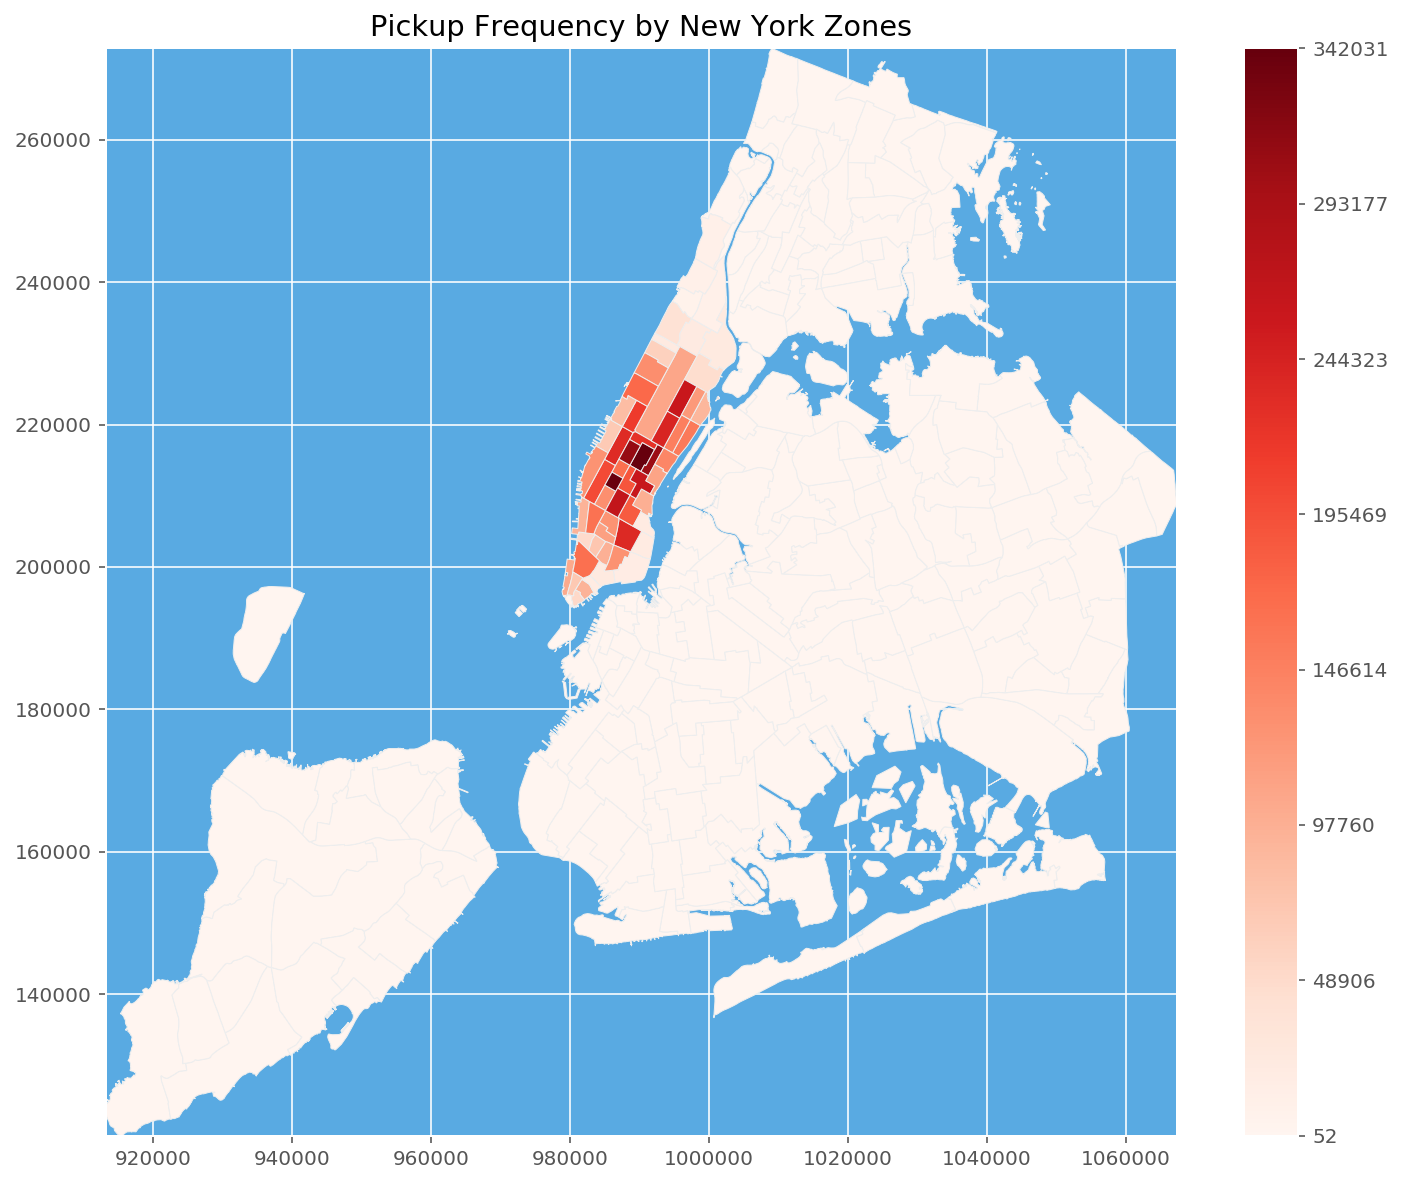

In [41]:
figure = plt.figure(figsize=(12,10))
ax = plt.axes()
ax.set_title("Pickup Frequency by New York Zones")
PUcount = dict(nyc_df['PULocationID'].value_counts().sort_values())
draw_zone_map(ax, sf, heat=PUcount)

In [0]:
# years=[2017,2018]
# for year in years:
#   figure, ax1 = plt.subplots(figsize=(12,10))
#   ax2 = ax1.twinx()
#   sns.set(style="white")
#   sns.set(style="ticks")
#   sns.lineplot(nyc_df['tpep_pickup_datetime'].loc[nyc_df['tpep_pickup_datetime'].dt.year == year].dt.dayofyear, nyc_df['rain'].loc[nyc_df['tpep_pickup_datetime'].dt.year == year],ax=ax1,color="coral", label="rain")
#   sns.lineplot(np.arange(1,32), nyc_df['tpep_pickup_datetime'].loc[nyc_df['tpep_pickup_datetime'].dt.year == year].dt.dayofyear.value_counts(sort=False), ax=ax2, label="pickup counts")
#   ax1.set_ylim(bottom= -1, top=50)
#   ax2.set_ylim(bottom=800, top=3500)
#   ax1.set(xlabel="day of year", ylabel="rain (mm)", title="Precipitation vs. Pickup Counts in {:4d}".format(year))
#   ax2.set(ylabel="count")
#   ax1.legend(loc = (0,.95), frameon = False)
#   ax2.legend( loc = (0, .90), frameon = False)

In [0]:
# years=[2017,2018]
# for year in years:
#   figure, ax1 = plt.subplots(figsize=(12,10))
#   ax2 = ax1.twinx()
#   sns.set(style="white")
#   sns.set(style="ticks")
#   sns.lineplot(nyc_df['tpep_pickup_datetime'].loc[nyc_df['tpep_pickup_datetime'].dt.year == year].dt.dayofyear, nyc_df['temperature_avg'].loc[nyc_df['tpep_pickup_datetime'].dt.year == year],ax=ax1,color="coral", label="avg temperature")
#   sns.lineplot(np.arange(1,32), nyc_df['tpep_pickup_datetime'].loc[nyc_df['tpep_pickup_datetime'].dt.year == year].dt.dayofyear.value_counts(sort=False), ax=ax2, label="pickup counts")
#   ax1.set_ylim(bottom= -15, top=50)
#   ax2.set_ylim(bottom=800, top=3500)
#   ax1.set(xlabel="day of year", ylabel="avg temperature (C)", title="Average Temperature vs. Pickup Counts in {:4d}".format(year))
#   ax2.set(ylabel="count")
#   ax1.legend(loc = (0,.95), frameon = False)
#   ax2.legend( loc = (0, .90), frameon = False)

In [0]:
# years=[2017,2018]
# for year in years:
#   figure, ax1 = plt.subplots(figsize=(12,10))
#   ax2 = ax1.twinx()
#   sns.set(style="white")
#   sns.set(style="ticks")
#   sns.lineplot(nyc_df['tpep_pickup_datetime'].loc[nyc_df['tpep_pickup_datetime'].dt.year == year].dt.dayofyear, nyc_df['humidity_avg'].loc[nyc_df['tpep_pickup_datetime'].dt.year == year],ax=ax1,color="coral", label="avg humidity")
#   sns.lineplot(np.arange(1,32), nyc_df['tpep_pickup_datetime'].loc[nyc_df['tpep_pickup_datetime'].dt.year == year].dt.dayofyear.value_counts(sort=False), ax=ax2, label="pickup counts")
#   ax1.set_ylim(bottom= 40, top=150)
#   ax2.set_ylim(bottom=800, top=3500)
#   ax1.set(xlabel="day of year", ylabel="avg humidity (%)", title="Average Humidity vs. Pickup Counts in {:4d}".format(year))
#   ax2.set(ylabel="count")
#   ax1.legend(loc = (0,.95), frameon = False)
#   ax2.legend( loc = (0, .90), frameon = False)

## Produce the target data for training

####Check that all is good with nyc_df

In [45]:
nyc_df

,tpep_pickup_datetime,VendorID,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,precipitation,temp_avg,humidity_avg,dayOfMonth,dayOfWeek
2017-01-01,2017-01-01 00:00:02,2,2017-01-01 00:39:22,4,7.75,1,N,186,36,1,22.0,0.5,0.5,4.66,0.0,0.3,27.96,0.0,7,41,1,6
2017-01-01,2017-01-01 00:00:06,1,2017-01-01 00:23:37,2,12.60,5,N,161,265,1,60.0,0.0,0.0,10.00,0.0,0.3,70.30,0.0,7,41,1,6
2017-01-01,2017-01-01 00:00:10,1,2017-01-01 00:24:52,1,6.60,1,N,186,232,2,23.0,0.5,0.5,0.00,0.0,0.3,24.30,0.0,7,41,1,6
2017-01-01,2017-01-01 00:00:12,1,2017-01-01 00:12:53,1,1.70,1,N,125,45,2,9.5,0.5,0.5,0.00,0.0,0.3,10.80,0.0,7,41,1,6
2017-01-01,2017-01-01 00:00:13,2,2017-01-01 00:15:39,1,4.68,1,N,140,223,1,16.5,0.5,0.5,4.45,0.0,0.3,22.25,0.0,7,41,1,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-01-31,2019-01-31 23:59:51,2,2019-02-01 00:28:56,6,11.23,1,N,125,247,1,34.0,0.5,0.5,7.06,0.0,0.3,42.36,0.0,-13,42,31,3
2019-01-31,2019-01-31 23:59:51,1,2019-02-01 00:23:33,2,6.50,1,N,4,41,1,21.5,1.0,0.5,3.50,0.0,0.3,26.80,0.0,-13,42,31,3
2019-01-31,2019-01-31 23:59:51,1,2019-02-01 00:30:54,1,6.90,1,Y,158,7,1,25.5,0.5,0.5,5.35,0.0,0.3,32.15,0.0,-13,42,31,3
2019-01-31,2019-01-31 23:59:52,1,2019-02-01 00:34:16,1,9.80,1,Y,164,160,2,33.0,0.5,0.5,0.00,0.0,0.3,34.30,0.0,-13,42,31,3


#### Produce a 2017 and 2018 dataframe

2017 and 2018 will act as training and 2019 as testing

In [0]:
df_17 = nyc_df.loc[(nyc_df["tpep_pickup_datetime"].dt.year == 2017)]
df_18 = nyc_df.loc[(nyc_df["tpep_pickup_datetime"].dt.year == 2018)]
df_19 = nyc_df.loc[(nyc_df["tpep_pickup_datetime"].dt.year == 2019)]

df_17 = df_17.drop(columns=[  'tpep_pickup_datetime',
                              'tpep_dropoff_datetime',
                              'DOLocationID',
                              'VendorID',
                              'RatecodeID',
                              'store_and_fwd_flag',
                              'payment_type',
                              'passenger_count',
                              'fare_amount',
                              'total_amount',
                              'trip_distance',
                              'extra',
                              'mta_tax',
                              'tip_amount',
                              'tolls_amount',
                              'improvement_surcharge'])

df_18 = df_18.drop(columns=[  'tpep_pickup_datetime',
                              'tpep_dropoff_datetime',
                              'DOLocationID',
                              'VendorID',
                              'RatecodeID',
                              'store_and_fwd_flag',
                              'payment_type',
                              'passenger_count',
                              'fare_amount',
                              'total_amount',
                              'trip_distance',
                              'extra',
                              'mta_tax',
                              'tip_amount',
                              'tolls_amount',
                              'improvement_surcharge'])

df_19 = df_19.drop(columns=[  'tpep_pickup_datetime',
                              'tpep_dropoff_datetime',
                              'DOLocationID',
                              'VendorID',
                              'RatecodeID',
                              'store_and_fwd_flag',
                              'payment_type',
                              'passenger_count',
                              'fare_amount',
                              'total_amount',
                              'trip_distance',
                              'extra',
                              'mta_tax',
                              'tip_amount',
                              'tolls_amount',
                              'improvement_surcharge'])



In [0]:
df_17_counts = df_17.groupby(['dayOfMonth','PULocationID']).size().reset_index(name='count')['count']
df_17 = df_17.drop_duplicates(['dayOfMonth','PULocationID'])
df_17 = df_17.reset_index(drop=True)
df_17['counts'] = df_17_counts

df_18_counts = df_18.groupby(['dayOfMonth','PULocationID']).size().reset_index(name='count')['count']
df_18 = df_18.drop_duplicates(['dayOfMonth','PULocationID'])
df_18 = df_18.reset_index(drop=True)
df_18['counts'] = df_18_counts

df_19_counts = df_19.groupby(['dayOfMonth','PULocationID']).size().reset_index(name='count')['count']
df_19 = df_19.drop_duplicates(['dayOfMonth','PULocationID'])
df_19 = df_19.reset_index(drop=True)
df_19['counts'] = df_19_counts



In [48]:
df_17

,PULocationID,precipitation,temp_avg,humidity_avg,dayOfMonth,dayOfWeek,counts
0,186,0.00,7,41,1,6,545
1,161,0.00,7,41,1,6,102
2,125,0.00,7,41,1,6,1020
3,140,0.00,7,41,1,6,276
4,68,0.00,7,41,1,6,411
...,...,...,...,...,...,...,...
1990,224,1.52,-1,64,31,1,1423
1991,120,1.52,-1,64,31,1,1783
1992,194,1.52,-1,64,31,1,774
1993,128,1.52,-1,64,31,1,1291


In [49]:
df_18

,PULocationID,precipitation,temp_avg,humidity_avg,dayOfMonth,dayOfWeek,counts
0,90,0.0,-11,50,1,0,343
1,161,0.0,-11,50,1,0,109
2,158,0.0,-11,50,1,0,710
3,237,0.0,-11,50,1,0,187
4,170,0.0,-11,50,1,0,250
...,...,...,...,...,...,...,...
2001,243,0.0,-3,44,31,2,1403
2002,12,0.0,-3,44,31,2,1713
2003,127,0.0,-3,44,31,2,821
2004,194,0.0,-3,44,31,2,1209


In [50]:
df_19

,PULocationID,precipitation,temp_avg,humidity_avg,dayOfMonth,dayOfWeek,counts
0,237,1.52,9,74,1,1,209
1,114,1.52,9,74,1,1,89
2,161,1.52,9,74,1,1,584
3,233,1.52,9,74,1,1,149
4,50,1.52,9,74,1,1,221
...,...,...,...,...,...,...,...
2014,152,0.00,-13,42,31,3,1291
2015,127,0.00,-13,42,31,3,1357
2016,12,0.00,-13,42,31,3,707
2017,153,0.00,-13,42,31,3,978


In [51]:

print(df_17.shape)
print(df_18.shape)
print(df_19.shape)

(1995, 7)
(2006, 7)
(2019, 7)


In [0]:
df_17_18 = df_17.append(df_18, ignore_index=True)

In [53]:
print(df_17_18.shape)
print(df_19.shape)

(4001, 7)
(2019, 7)


## Remove unused features before the training 

In [54]:
#target=nycmodel[['count']]
#data=nycmodel[[col for col in nycmodel.columns if col not in ['count']]]

x_train = df_17_18.drop(columns=['counts'])
y_train = df_17_18['counts']

x_test  = df_19.drop(columns=['counts'])
y_test  = df_19['counts']
# x_train = nyc_df['tpep_pickup_datetime'].dt.year == 2017

print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(4001, 6)
(2019, 6)
(4001,)
(2019,)


In [55]:
x_train

,PULocationID,precipitation,temp_avg,humidity_avg,dayOfMonth,dayOfWeek
0,186,0.0,7,41,1,6
1,161,0.0,7,41,1,6
2,125,0.0,7,41,1,6
3,140,0.0,7,41,1,6
4,68,0.0,7,41,1,6
...,...,...,...,...,...,...
3996,243,0.0,-3,44,31,2
3997,12,0.0,-3,44,31,2
3998,127,0.0,-3,44,31,2
3999,194,0.0,-3,44,31,2


In [56]:
y_train

0        545
1        102
2       1020
3        276
4        411
        ... 
3996    1403
3997    1713
3998     821
3999    1209
4000    1504
Name: counts, Length: 4001, dtype: int64

## Linear Regression

In [0]:
def linearRegression(x_train, y_train, x_test, y_test):
    
    #standardizing the data
    x_train_std = StandardScaler().fit_transform(x_train)
    x_test_std = StandardScaler().fit_transform(x_test)
    
    #hyper-paramater tuning
    clf = SGDRegressor(loss = "squared_loss", penalty = "l2")
    values = [10**-14, 10**-12, 10**-10, 10**-8, 10**-6, 10**-4, 10**-2, 10**0, 10**2, 110, 120, 130, 131, 135, 140, 145, 150, 160, 170, 10**4, 10**6]
    hyper_parameter = {"alpha": values}
    best_parameter = GridSearchCV(clf, hyper_parameter, scoring = "neg_mean_absolute_error", cv=KFold(n_splits=3, random_state=1, shuffle=True))
    best_parameter.fit(x_train_std, y_train)
    alpha = best_parameter.best_params_["alpha"]
    print("alpha: " + str(alpha))
    
    #applying linear regression with best hyper-parameter
    clf = SGDRegressor(loss = "squared_loss", penalty = "l2", alpha = alpha)
    clf.fit(x_train_std, y_train)
    y_pred = clf.predict(x_train_std)
    train_MAPE = mean_absolute_error(y_train, y_pred)/ (sum(y_train)/len(y_train))
    train_MSE = mean_squared_error(y_train, y_pred)
    y_pred = clf.predict(x_test_std)
    test_MAPE = mean_absolute_error(y_test, y_pred)/ (sum(y_test)/len(y_test))
    test_MSE = mean_squared_error(y_test, y_pred)
    r2 = clf.score(x_test_std,y_test)
    
    return train_MAPE, train_MSE, test_MAPE, test_MSE, r2
  

# Random Forests


In [0]:

def randomForest(x_train, y_train, x_test, y_test):
  values = [320, 350, 400, 500, 600, 700, 800, 900]
  clf = RandomForestRegressor(n_jobs = -1)
  hyper_parameter = {"n_estimators": values}
  best_parameter = GridSearchCV(clf, hyper_parameter, scoring = "neg_mean_absolute_error", cv=KFold(n_splits=3, random_state=1, shuffle=True), verbose=2)
  best_parameter.fit(x_train, y_train)
  estimators = best_parameter.best_params_["n_estimators"]
  print("estimators: " + str(estimators))

  #applying random forest with best hyper-parameter
  clf = RandomForestRegressor(n_estimators = estimators, n_jobs = -1, oob_score=True)
  clf.fit(x_train, y_train)
  y_pred = clf.predict(x_train)
  train_MAPE = mean_absolute_error(y_train, y_pred)/ (sum(y_train)/len(y_train))
  train_MSE = mean_squared_error(y_train, y_pred)
  y_pred = clf.predict(x_test)
  test_MAPE = mean_absolute_error(y_test, y_pred)/ (sum(y_test)/len(y_test))
  test_MSE = mean_squared_error(y_test, y_pred)
  train_accuracy = clf.score(x_train, y_train)
  test_accuracy = clf.score(x_test, y_test)


  feature_importances = clf.feature_importances_
  oob_score = clf.oob_score_

  
  return train_MAPE, train_MSE, test_MAPE, test_MSE, train_accuracy, test_accuracy, feature_importances, oob_score


# K Neighbors Regressor

In [0]:
def kNeighbors(x_train, y_train, x_test, y_test):
  n_neighbors = [5, 10, 15, 20, 30]
  clf = KNeighborsRegressor(n_jobs = -1)
  hyper_parameter = {"n_neighbors": n_neighbors}
  best_parameter = GridSearchCV(clf, hyper_parameter, scoring = "neg_mean_absolute_error", cv = KFold(n_splits=3, random_state=1, shuffle=True), verbose=2)
  best_parameter.fit(x_train, y_train)
  neighbors = best_parameter.best_params_["n_neighbors"]
  print("neighbors: " + str(neighbors))

  clf = KNeighborsRegressor(n_neighbors = neighbors, n_jobs = -1)
  clf.fit(x_train, y_train)
  y_pred = clf.predict(x_train)
  train_MAPE = mean_absolute_error(y_train, y_pred)/ (sum(y_train)/len(y_train))
  train_MSE = mean_squared_error(y_train, y_pred)
  y_pred = clf.predict(x_test)
  test_MAPE = mean_absolute_error(y_test, y_pred)/ (sum(y_test)/len(y_test))
  test_MSE = mean_squared_error(y_test, y_pred)
  train_accuracy = clf.score(x_train, y_train)
  test_accuracy = clf.score(x_test, y_test)
  
  return train_MAPE, train_MSE, test_MAPE, test_MSE, train_accuracy, test_accuracy


# XgBoost Regressor

In [0]:
def xgboost_reg(x_train, y_train, x_test, y_test):
    #hyper-parameter tuning
    hyper_parameter = {"max_depth":[1,2,3,4,5,6], "n_estimators":[40, 80, 150, 300, 500, 600], "objective":['reg:squarederror']}
    clf = xgb.XGBRegressor()
    best_parameter = GridSearchCV(clf, hyper_parameter, scoring = "neg_mean_absolute_error", cv= KFold(n_splits=3, random_state=1, shuffle=True))
    best_parameter.fit(x_train, y_train)
    estimators = best_parameter.best_params_["n_estimators"]
    depth = best_parameter.best_params_["max_depth"]
    print("estimators: " + str(estimators))
    print("depth: " + str(depth))
    
    #applying xgboost regressor with best hyper-parameter
    clf = xgb.XGBRegressor(max_depth = depth, n_estimators = estimators)
    clf.fit(x_train, y_train)
    y_pred = clf.predict(x_train)
    train_MAPE = mean_absolute_error(y_train, y_pred)/ (sum(y_train)/len(y_train))
    train_MSE = mean_squared_error(y_train, y_pred)
    y_pred = clf.predict(x_test)
    test_MAPE = mean_absolute_error(y_test, y_pred)/ (sum(y_test)/len(y_test))
    test_MSE = mean_squared_error(y_test, y_pred)
    train_accuracy = clf.score(x_train, y_train)
    test_accuracy = clf.score(x_test, y_test)
    
    return train_MAPE, train_MSE, test_MAPE, test_MSE, train_accuracy, test_accuracy


# Testing

In [62]:
#Linear Regression Model
trainMAPE_lr, trainMSE_lr, testMAPE_lr, testMSE_lr, r2 = linearRegression(x_train, y_train, x_test, y_test)
print(trainMAPE_lr*100, trainMSE_lr, testMAPE_lr*100, testMSE_lr, r2)

alpha: 1e-14
71.79861822939507 1410132.09243718 81.74325932881624 1046655.7709226372 -0.07540069576668373


In [63]:
#Random Forest Model
trainMAPE_rf, trainMSE_rf, testMAPE_rf, testMSE_rf, train_accuracy, test_accuracy, feature_importances_rf, oob_score_rf = randomForest(x_train, y_train, x_test, y_test)
print(trainMAPE_rf*100, trainMSE_rf, testMAPE_rf*100, testMSE_rf, oob_score_rf, train_accuracy, test_accuracy)

Fitting 3 folds for each of 8 candidates, totalling 24 fits
[CV] n_estimators=320 ................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ................................. n_estimators=320, total=   3.3s
[CV] n_estimators=320 ................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.3s remaining:    0.0s


[CV] ................................. n_estimators=320, total=   2.9s
[CV] n_estimators=320 ................................................
[CV] ................................. n_estimators=320, total=   2.9s
[CV] n_estimators=350 ................................................
[CV] ................................. n_estimators=350, total=   3.1s
[CV] n_estimators=350 ................................................
[CV] ................................. n_estimators=350, total=   3.1s
[CV] n_estimators=350 ................................................
[CV] ................................. n_estimators=350, total=   3.1s
[CV] n_estimators=400 ................................................
[CV] ................................. n_estimators=400, total=   3.2s
[CV] n_estimators=400 ................................................
[CV] ................................. n_estimators=400, total=   3.3s
[CV] n_estimators=400 ................................................
[CV] .

[Parallel(n_jobs=1)]: Done  24 out of  24 | elapsed:  1.5min finished


estimators: 400
27.9195233715612 217035.11021087694 82.57515680330955 1112606.0254540213 -0.1170642912592803 0.8483421190515441 -0.14316218104137057


In [64]:
#XGB Model
trainMAPE_xgb, trainMSE_xgb, testMAPE_xgb, testMSE_xgb, train_accuracy, test_accuracy= xgboost_reg(x_train, y_train, x_test, y_test)
print(trainMAPE_xgb*100, trainMSE_xgb, testMAPE_xgb*100, testMSE_xgb, train_accuracy, test_accuracy)

/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/x

estimators: 40
depth: 3
[08:50:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
68.97922267641674 1319462.3031985469 79.92417359904704 1008289.9205805195 0.07799776404826031 -0.03598118144515672


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


In [65]:
#KNR Model
trainMAPE_knr, trainMSE_knr, testMAPE_knr, testMSE_knr, train_accuracy, test_accuracy= kNeighbors(x_train, y_train, x_test, y_test)
print(trainMAPE_knr*100, trainMSE_knr, testMAPE_knr*100, testMSE_knr, train_accuracy, test_accuracy)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV] n_neighbors=5 ...................................................
[CV] .................................... n_neighbors=5, total=   1.8s
[CV] n_neighbors=5 ...................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.8s remaining:    0.0s


[CV] .................................... n_neighbors=5, total=   1.8s
[CV] n_neighbors=5 ...................................................
[CV] .................................... n_neighbors=5, total=   1.8s
[CV] n_neighbors=10 ..................................................
[CV] ................................... n_neighbors=10, total=   1.8s
[CV] n_neighbors=10 ..................................................
[CV] ................................... n_neighbors=10, total=   1.8s
[CV] n_neighbors=10 ..................................................
[CV] ................................... n_neighbors=10, total=   1.8s
[CV] n_neighbors=15 ..................................................
[CV] ................................... n_neighbors=15, total=   1.8s
[CV] n_neighbors=15 ..................................................
[CV] ................................... n_neighbors=15, total=   1.8s
[CV] n_neighbors=15 ..................................................
[CV] .

[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:   26.7s finished


70.05933795401101 1347247.9653058958 83.80345094375895 1103577.1843982171 0.05858194403712946 -0.13388537559766722


In [66]:
feature_importances_rf

array([0.5554627 , 0.04837769, 0.10020335, 0.1021409 , 0.11699362,
       0.07682174])

Text(0.5, 1.0, '')

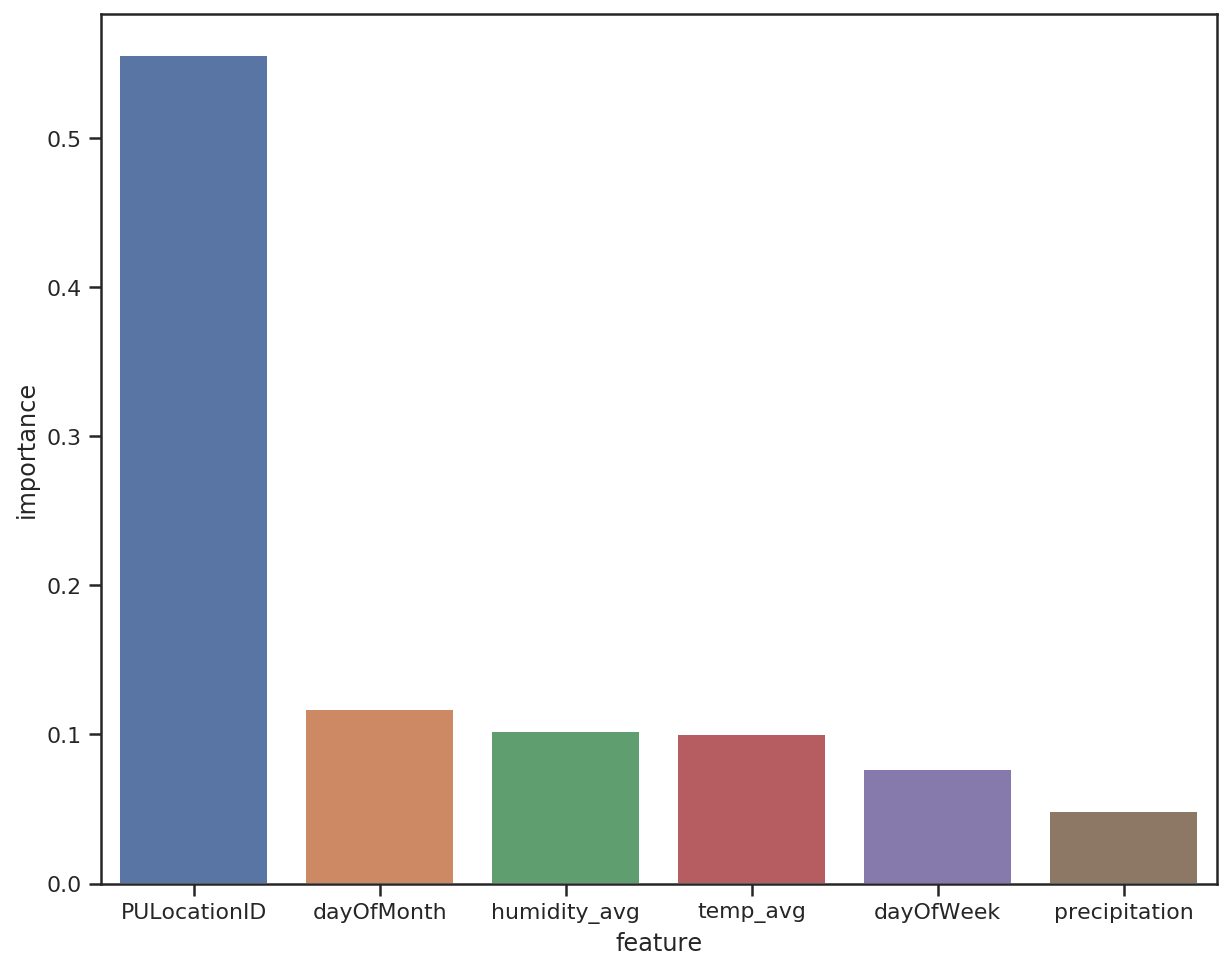

In [67]:
import seaborn as sns
feature_importance_tuple = list(zip(x_train.columns,feature_importances_rf))
df_feature_importances = pd.DataFrame(feature_importance_tuple, columns=['feature','importance']).sort_values('importance',ascending=False)
df_feature_importances
plt.figure(figsize=(10,8))
sns.set(style="white")
sns.set(style="ticks")
ax = sns.barplot(x="feature", y="importance", data=df_feature_importances)
ax.set_title("")


# Plotting Mean Absolute Percentage Error


(70, 81.7845)

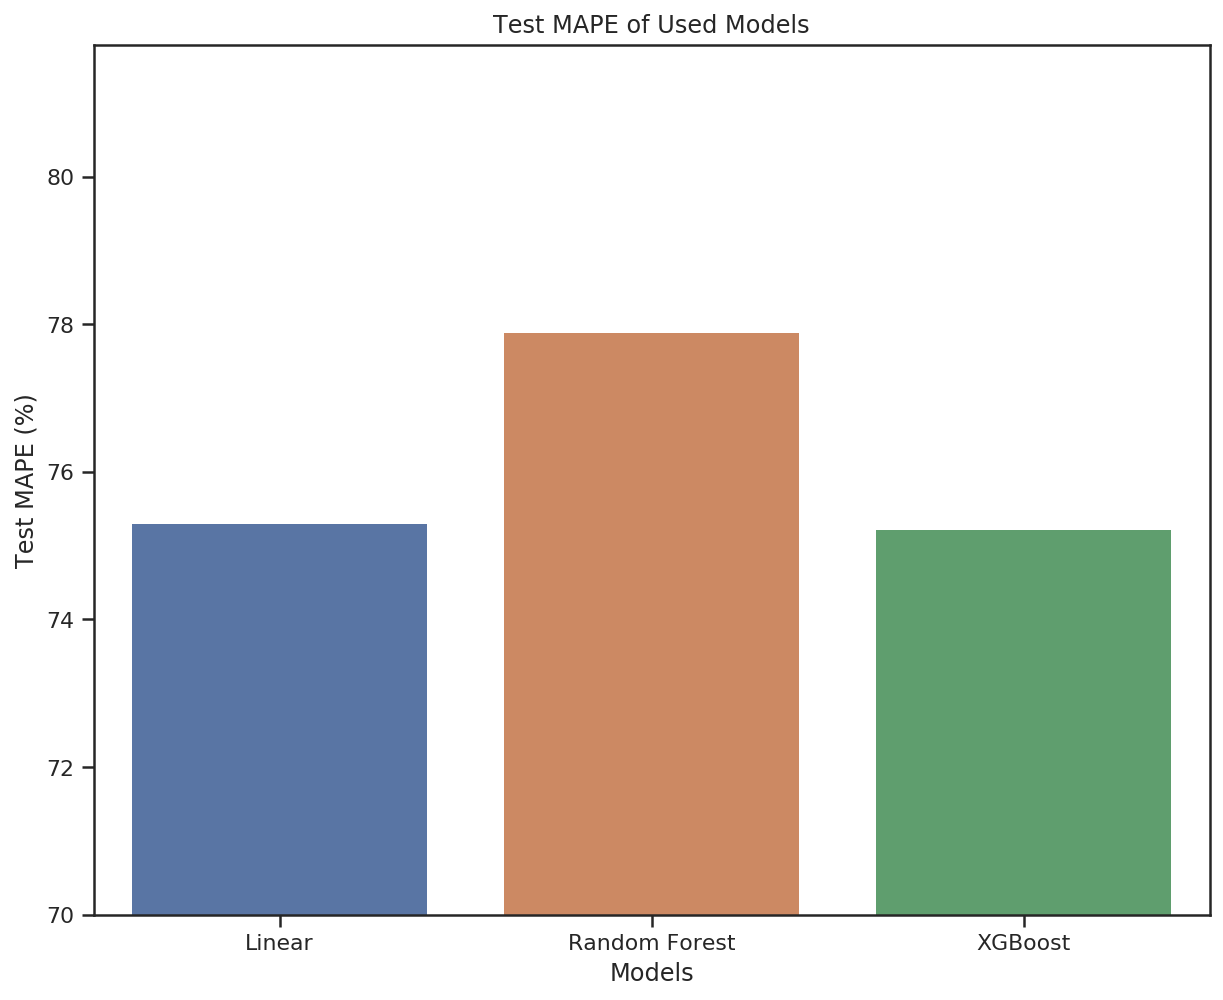

In [80]:
# Original Results
mape = {'Models': ['Linear', 'Random Forest', 'XGBoost'], 'Test MAPE (%)': [75.31, 77.89, 75.23]}
df_mape = pd.DataFrame(data=mape)
plt.figure(figsize=(10,8))
sns.set(style="white")
sns.set(style="ticks")
ax = sns.barplot(x="Models", y="Test MAPE (%)", data=df_mape)
ax.set_title("Test MAPE of Used Models")
ax.set_ylim(70, None)

(70, 87.99)

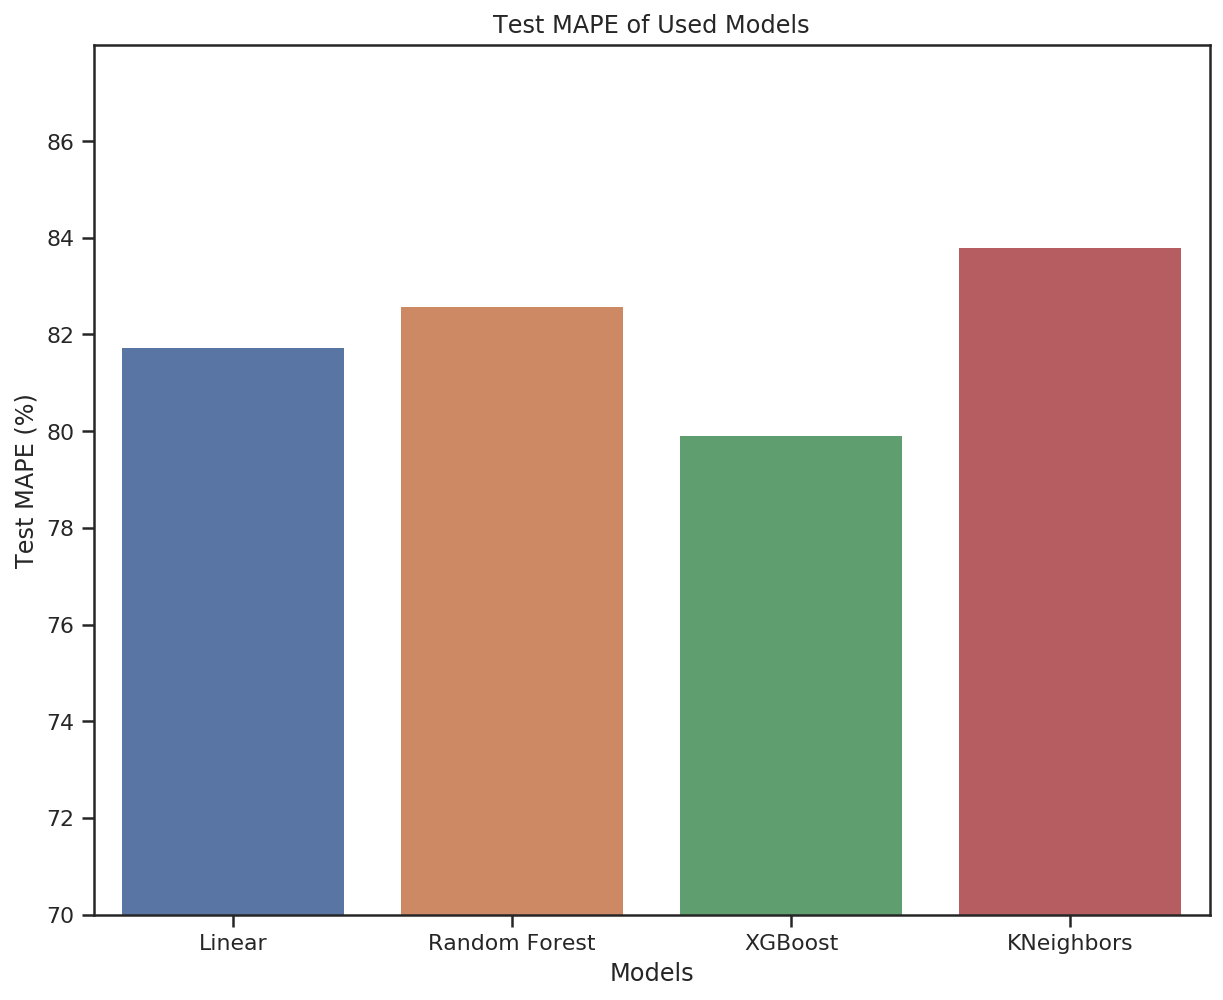

In [81]:
# New Results
mape = {'Models': ['Linear', 'Random Forest', 'XGBoost', 'KNeighbors'], 'Test MAPE (%)': [81.74, 82.58, 79.92, 83.8]}
df_mape = pd.DataFrame(data=mape)
plt.figure(figsize=(10,8))
sns.set(style="white")
sns.set(style="ticks")
ax = sns.barplot(x="Models", y="Test MAPE (%)", data=df_mape)
ax.set_title("Test MAPE of Used Models")
ax.set_ylim(70, None)